In [1]:
"""Notebok loads & explores the dataset.
It performs basic cleaning & prepares the data for training.
"""

'Notebok loads & explores the dataset.\nIt performs basic cleaning & prepares the data for training.\n'

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
data_path = pathlib.Path('./data/Thesis All Data.xlsx')

In [17]:
df = pd.read_excel(data_path, header = 0, na_values='--', verbose=True, sheet_name='ALL')

Reading sheet ALL


In [18]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Nofsimnum,Step No.,Time,Load X,Load Y
0,0.2,0.2,1.5,1,-1,0.000000,NaN,NaN
1,0.2,0.2,1.5,1,1,136680.987801,598346.0,671413.0
2,0.2,0.2,1.5,1,2,179087.315076,767689.0,738346.0
3,0.2,0.2,1.5,1,3,213728.844488,889873.0,138438.0
4,0.2,0.2,1.5,1,4,2483.703739,960976.0,14598.0


In [19]:
len(df)

2063

In [20]:
# There are several redundant features that do not add information.
# Time, as it is just the time od of the simulation step.
# Simulation steps, also do not contain information and are only applicable in simulation environment.
# Nofsimnum has only 1s - does not contain information.
df['Nofsimnum'].unique()

array([1])

In [21]:
# Remove reduntant features.
df = df.loc[:, df.columns != 'Time']
df = df.loc[:, df.columns != 'Step No.']
df = df.loc[:, df.columns != 'Nofsimnum']

In [22]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
0,0.2,0.2,1.5,NaN,NaN
1,0.2,0.2,1.5,598346.0,671413.0
2,0.2,0.2,1.5,767689.0,738346.0
3,0.2,0.2,1.5,889873.0,138438.0
4,0.2,0.2,1.5,960976.0,14598.0


In [23]:
# Clean the NaN values.
df = df.dropna()

In [24]:
len(df)

2058

In [25]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.2,0.2,1.5,598346.0,671413.0
2,0.2,0.2,1.5,767689.0,738346.0
3,0.2,0.2,1.5,889873.0,138438.0
4,0.2,0.2,1.5,960976.0,14598.0
5,0.2,0.2,1.5,998679.0,141208.0


In [26]:
df.tail()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
2058,0.2,0.3,0.5,586787.0,280243.0
2059,0.2,0.3,0.5,611118.0,342393.0
2060,0.2,0.3,0.5,622466.0,367928.0
2061,0.2,0.3,0.5,630343.0,380485.0
2062,0.2,0.3,0.5,632184.0,384579.0


In [27]:
# Extrapolate min and max versions before normalization, for backward conversion of loads.
print("Load X min", df['Load X'].min())
print("Load X max", df['Load X'].max())
print("Load Y min", df['Load Y'].min())
print("Load Y max", df['Load Y'].max())

Load X min 53.31
Load X max 999049.0
Load Y min 101.93
Load Y max 998309.0


In [28]:
# Normalize the output variables.
df['Load X']=(df['Load X']-df['Load X'].min())/(df['Load X'].max()-df['Load X'].min())
df['Load Y']=(df['Load X']-df['Load X'].min())/(df['Load X'].max()-df['Load X'].min())

In [29]:
df.head()

,Depth Of Cut,Feed Rate,Lenght Of Cut,Load X,Load Y
1,0.2,0.2,1.5,0.598894,0.598894
2,0.2,0.2,1.5,0.768407,0.768407
3,0.2,0.2,1.5,0.890714,0.890714
4,0.2,0.2,1.5,0.961889,0.961889
5,0.2,0.2,1.5,0.999630,0.999630


In [14]:
# Visualize the cleaned data.

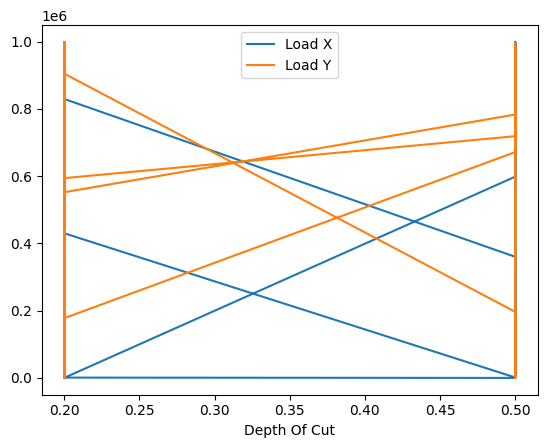

In [15]:
df.plot(x="Depth Of Cut", y=["Load X", "Load Y"], kind='line')
plt.show()

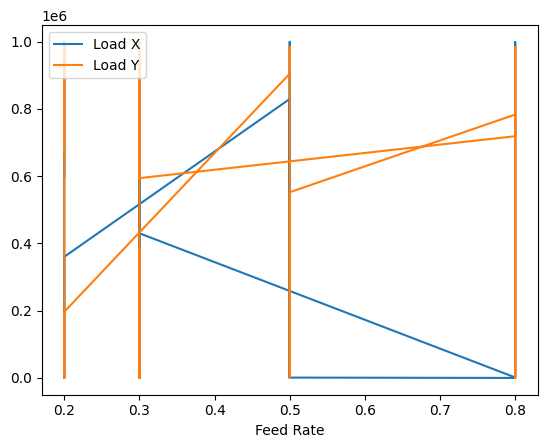

In [16]:
df.plot(x="Feed Rate", y=["Load X", "Load Y"], kind='line')
plt.show()

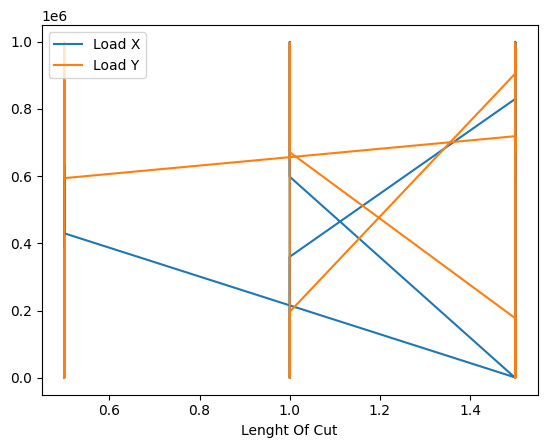

In [17]:
df.plot(x="Lenght Of Cut", y=["Load X", "Load Y"], kind='line')
plt.show()

In [92]:
# Export the cleaned data.
df.to_csv('./data/thesis_data_cleaned.csv', index=False)